In [ ]:
import ast
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 설정 (시각화용) - 에러 방지 버전
try:
    import matplotlib.font_manager as fm
    # 사용 가능한 한글 폰트 찾기
    font_list = [f.name for f in fm.fontManager.ttflist if 'Gothic' in f.name or '한글' in f.name]
    
    if font_list:
        plt.rcParams['font.family'] = font_list[0]
    else:
        # 한글 폰트가 없으면 DejaVu Sans 사용 (영어만)
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("⚠️ 한글 폰트를 찾을 수 없어 영어 폰트를 사용합니다.")
        
    plt.rcParams['axes.unicode_minus'] = False
except:
    # 폰트 설정 실패시 기본 폰트 사용
    print("⚠️ 폰트 설정을 건너뜁니다. 그래프는 영어로 표시됩니다.")

# 1. EDA
- 결측값이 존재하지 않으므로 전처리 진행은 원활할 것으로 예상
- 의미를 알 수 없는 unnamed 피쳐 들은 제거 예정
- 고유 피쳐가 상당 수 존재해 세밀한 구분이 가능
- 평가와 평점 편향이 크게 분포해서 학습을 위해 정규화 등의 개선이 필요함
- 샘플 수가 적음.. 하지만 문제가 되진 않는듯

### 결론
- 전체적으로 완벽한 데이터 (가공 데이터를 가져왔으므로 당연하지만..)이므로 큰 전처리 작업은 불필요해보임
- 평점, 편향에서 편향이 심하므로 정규화가 필요함
- 범주형 피쳐에 멀티-핫 인코딩으로 피쳐 벡터화 처리가 필수. 하지만 고유 피쳐가 많으므로.. PCA도 고려해야함

In [3]:
# 데이터 불러오기
df = pd.read_csv('맥주_cbf_data.csv')

# 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(f"데이터 형태: {df.shape}")
print(f"컬럼 목록: {df.columns.tolist()}")
print(f"결측값: {df.isnull().sum().sum()}개")

# 처음 5개 행 확인
print("\n=== 처음 5개 맥주 ===")
print(df.head())

=== 데이터 기본 정보 ===
데이터 형태: (77, 14)
컬럼 목록: ['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', '맥주이름', '맥주스타일', 'Main Category', 'Aroma', 'Flavor', 'Balance', 'Season', 'Paring Food', 'Body', '평점평균', '평가횟수']
결측값: 0개

=== 처음 5개 맥주 ===
   Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1                    맥주이름  \
0             0           0             0  Kloud Original Gravity   
1             1           1             2         Asahi Super Dry   
2             2           2             3                Tsingtao   
3             3           3             4                Heineken   
4             4           4             5           Kirin Ichiban   

                                  맥주스타일 Main Category  \
0  Pale Lager - International / Premium            라거   
1  Pale Lager - International / Premium            라거   
2  Pale Lager - International / Premium            라거   
3  Pale Lager - International / Premium            라거   
4  Pale Lager - International / Premium            라거   

              

In [ ]:
# 데이터 형태 확인
print("Aroma 첫 번째 값:", repr(df['Aroma'].iloc[0]))
print("타입:", type(df['Aroma'].iloc[0]))

Aroma 첫 번째 값: "['고소한 맥아향', '강한 향', '빵 향', '달콤한 향', '풀잎 향']"
타입: <class 'str'>


In [ ]:
# 특성 컬럼들
feature_columns = ['Aroma', 'Flavor', 'Balance', 'Body', 'Season', 'Paring Food']

def safe_parse_feature_list(feature_str):
    """
    안전하게 특성 리스트를 파싱하는 함수 - 에러 방지
    """
    # NaN이나 None 체크
    if pd.isna(feature_str) or feature_str is None:
        return []
    
    # 이미 리스트인 경우
    if isinstance(feature_str, list):
        return feature_str
    
    # 문자열로 변환
    if not isinstance(feature_str, str):
        feature_str = str(feature_str)
    
    # 빈 문자열 체크
    if not feature_str.strip():
        return []
    
    # 여러 방법으로 파싱 시도
    try:
        return ast.literal_eval(feature_str)  # 가장 안전한 방법
    except:
        try:
            # 정규식으로 추출
            matches = re.findall(r"'([^']*)'", feature_str)
            return matches if matches else []
        except:
            print(f"파싱 실패: {repr(feature_str)}")
            return []

# 각 특성별 고유값 확인
print("\n=== 특성별 고유값 개수 ===")
for col in feature_columns:
    all_features = []
    for idx, row in df.iterrows():
        features = safe_parse_feature_list(row[col])
        if isinstance(features, list):  # 리스트인지 확인
            all_features.extend(features)
    
    unique_features = list(set(all_features))
    print(f"{col}: {len(unique_features)}개 고유 특성")
    print(f"  예시: {unique_features[:5]}")


=== 특성별 고유값 개수 ===
Aroma: 65개 고유 특성
  예시: ['스파이시한 향', '스컹크 향', '거친 맥아향', '단맛', '자몽향']
Flavor: 82개 고유 특성
  예시: ['부드러움', '낮은 알코올', '옅은 옥수수 향', '약한 홉 풍미', '단맛']
Balance: 28개 고유 특성
  예시: ['부드러움', '크리미', '다양한 밸런스를 가진 제품 존재', '홉의 풍미', '매우 달콤']
Body: 24개 고유 특성
  예시: ['약간의 매끄러움', '부드러움', '적은 탄산', '크리미', '미디움']
Season: 14개 고유 특성
  예시: ['연중내내', '기름진 음식', '따뜻한 날씨', '따듯한 날씨', '더운 여름']
Paring Food: 93개 고유 특성
  예시: ['브라트부르스트', '해산물', '케이준 생선', '애플 파이', '소시지']



=== 평점 데이터 분석 ===
            평점평균         평가횟수
count  77.000000    77.000000
mean    2.550572   990.740260
std     0.541489  1354.242985
min     1.537023     1.000000
25%     2.152472    30.000000
50%     2.448684   348.000000
75%     2.980000  1730.000000
max     4.100000  5624.000000


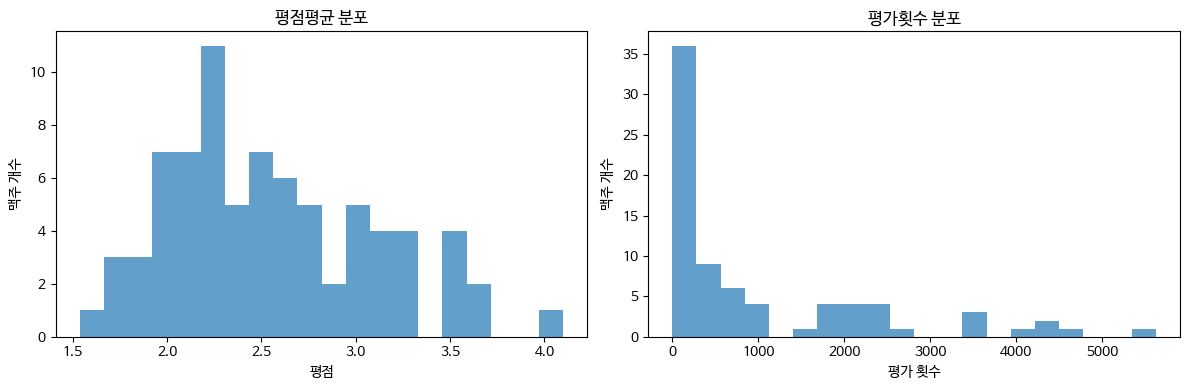

In [9]:
# 평점 데이터 분석
print("\n=== 평점 데이터 분석 ===")
print(df[['평점평균', '평가횟수']].describe())

# 평점 분포 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['평점평균'], bins=20, alpha=0.7)
plt.title('평점평균 분포')
plt.xlabel('평점')
plt.ylabel('맥주 개수')

plt.subplot(1, 2, 2)
plt.hist(df['평가횟수'], bins=20, alpha=0.7)
plt.title('평가횟수 분포')
plt.xlabel('평가 횟수')
plt.ylabel('맥주 개수')

plt.tight_layout()
plt.show()

In [11]:
class BeerFeatureExtractor:
    """
    맥주 특성을 벡터로 변환하는 클래스
    """
    def __init__(self):
        self.feature_columns = ['Aroma', 'Flavor', 'Balance', 'Body']
        self.all_features = {}  # 각 컬럼별 모든 고유 특성들
        self.feature_vectors = None  # 최종 특성 벡터
        
    def parse_feature_list(self, feature_str):
        """특성 문자열을 리스트로 변환 - 안전한 버전"""
        if pd.isna(feature_str) or feature_str is None:
            return []
        
        if isinstance(feature_str, list):
            return feature_str
            
        if not isinstance(feature_str, str):
            feature_str = str(feature_str)
            
        try:
            import ast
            result = ast.literal_eval(feature_str)
            # 결과가 리스트인지 확인하고, 아니면 빈 리스트 반환
            return result if isinstance(result, list) else []
        except:
            import re
            matches = re.findall(r"'([^']*)'", feature_str)
            return matches if matches else []
    
    def extract_all_features(self, df):
        """모든 고유 특성들을 추출"""
        print("=== 특성 추출 중... ===")
        
        for col in self.feature_columns:
            features_set = set()
            for idx, row in df.iterrows():
                features = self.parse_feature_list(row[col])
                # features가 실제로 리스트인지 다시 한번 확인
                if isinstance(features, list):
                    # 각 특성이 문자열인지 확인하고 추가
                    for feature in features:
                        if isinstance(feature, str) and feature.strip():
                            features_set.add(feature.strip())
                else:
                    print(f"경고: {col} 컬럼 {idx}행에서 리스트가 아닌 값: {type(features)}")
            
            self.all_features[col] = sorted(list(features_set))
            print(f"{col}: {len(self.all_features[col])}개 특성")
        
        return self.all_features
    
    def create_feature_vectors(self, df):
        """각 맥주를 특성 벡터로 변환"""
        print("\n=== 특성 벡터 생성 중... ===")
        
        # 모든 특성들을 하나의 리스트로 합치기
        all_feature_names = []
        for col in self.feature_columns:
            for feature in self.all_features[col]:
                all_feature_names.append(f"{col}_{feature}")
        
        print(f"총 특성 개수: {len(all_feature_names)}")
        
        # 원-핫 인코딩 수행
        feature_matrix = []
        
        for idx, row in df.iterrows():
            beer_vector = [0] * len(all_feature_names)  # 모든 특성을 0으로 초기화
            
            # 각 컬럼별로 해당 맥주가 가진 특성들을 1로 설정
            for col in self.feature_columns:
                beer_features = self.parse_feature_list(row[col])
                for feature in beer_features:
                    feature_name = f"{col}_{feature}"
                    if feature_name in all_feature_names:
                        feature_idx = all_feature_names.index(feature_name)
                        beer_vector[feature_idx] = 1
            
            feature_matrix.append(beer_vector)
        
        self.feature_vectors = np.array(feature_matrix)
        self.feature_names = all_feature_names
        
        print(f"특성 벡터 형태: {self.feature_vectors.shape}")
        return self.feature_vectors, all_feature_names

# 특성 추출기 사용
extractor = BeerFeatureExtractor()
all_features = extractor.extract_all_features(df)
feature_vectors, feature_names = extractor.create_feature_vectors(df)

=== 특성 추출 중... ===
Aroma: 65개 특성
Flavor: 82개 특성
Balance: 28개 특성
Body: 24개 특성

=== 특성 벡터 생성 중... ===
총 특성 개수: 199
특성 벡터 형태: (77, 199)


In [12]:
# 결과 확인
print("=== 처리 결과 ===")
print(f"맥주 개수: {len(df)}")
print(f"특성 개수: {len(feature_names)}")
print(f"특성 벡터 형태: {feature_vectors.shape}")

# 첫 번째 맥주의 특성 확인
print(f"\n=== 첫 번째 맥주 '{df.iloc[0]['맥주이름']}' 특성 ===")
beer_0_features = []
for i, has_feature in enumerate(feature_vectors[0]):
    if has_feature == 1:
        beer_0_features.append(feature_names[i])

print(f"가진 특성 개수: {len(beer_0_features)}")
print(f"특성 목록: {beer_0_features[:10]}...")  # 처음 10개만 출력

=== 처리 결과 ===
맥주 개수: 77
특성 개수: 199
특성 벡터 형태: (77, 199)

=== 첫 번째 맥주 'Kloud Original Gravity' 특성 ===
가진 특성 개수: 13
특성 목록: ['Aroma_강한 향', 'Aroma_고소한 맥아향', 'Aroma_달콤한 향', 'Aroma_빵 향', 'Aroma_풀잎 향', 'Flavor_상쾌함', 'Flavor_생강 힌트', 'Flavor_쓴 맛', 'Balance_미디엄', 'Body_가벼움']...
